In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

import astropy.units as u
from astropy.visualization import quantity_support
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty
from astroquery.nist import Nist # atomic lines
# from astroquery.linelists.cdms import CDMS # molecular lines?

from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum, fit_continuum

from scipy.integrate import trapz, simpson
from scipy.optimize import curve_fit
from scipy.signal import medfilt

# from astropy.io import ascii
from astropy.io import fits


%matplotlib inline

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

# Things that should only have to be defined once, here at the top
---

In [2]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

c = 299792458 # speed of light m/s
# Use Normalized (single) Gaussian Distribution
def gaussian_func(x,ampl,center,std):
    return ((ampl)/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x - center)/std)**2)) + 1

# Reduced and order-merged data filepath 
# Desktop path
# data_path = "A:\\Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged"

# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"
# File path for figures to live in
# Desktop path
# fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra"

# Laptop Path
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"


# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"/merged_standards/m*.fits")
standard_table = pd.read_csv('./standard_table_v2.txt',index_col=0) # csv of standards with file and Spectral Type, c/v TBA


standard_shift = standard_table['Wavelength Shift']
standard_list = standard_table['Source']

hops_table = pd.read_csv('./hops_table.txt')
hops_list = hops_table['Source']

# Determine the maximum length of flux arrays for the standards
max_flux_length = max(len(fits.getdata(file)[1]) for file in standard_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in standard_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in standard_list)

# Initialize flux_stack with NaN values
wavelen_stack = np.full((max_wavelen_length, len(standard_list)), np.nan)
raw_flux_stack = np.full((max_flux_length, len(standard_list)), np.nan)
flux_stack = np.full((max_flux_length, len(standard_list)), np.nan)
snr_stack = np.full((max_snr_length, len(standard_list)), np.nan)

raw_flux_err_stack = np.full((max_snr_length, len(standard_list)), np.nan)

# Fill flux_stack with flux data
for i, file in enumerate(standard_list):
    # Get data
    wavelen = fits.getdata(file)[0]
    flux = fits.getdata(file)[1]
    snr = fits.getdata(file)[2]

    median_flux = medfilt(flux, kernel_size=101)
    norm_flux = flux/median_flux
    
    # Clean data a bit
    snr_min = 50 # Minimum SNR
    # snr_max = 1e4 # Maxmimum SNR
    snr_cut = (snr > snr_min) #& (snr < snr_max) # bitwise SNR masking

    flux_min = 10000 # minimum flux
    flux_cut = flux > flux_min # bitwise flux masking

    wavelen_min = 2.0
    wavelen_max = 2.4
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    # Apply masks and remove NaNs and infs
    # snr_cut & 
    mask = flux_cut & wavelen_cut & snr_cut
    
    wavelen = wavelen[mask]
    flux = flux[mask]
    snr = snr[mask]
    norm_flux = norm_flux[mask]

    # Remove NaNs and infs from wavelen and norm_flux arrays
    valid_indices = ~np.isnan(wavelen) & ~np.isinf(wavelen) & ~np.isnan(norm_flux) & ~np.isinf(norm_flux) & ~np.isnan(flux) & ~np.isinf(flux) & ~np.isnan(snr) & ~np.isinf(snr)
    
    wavelen = wavelen[valid_indices] - standard_shift[i]
    flux = flux[valid_indices]
    norm_flux = norm_flux[valid_indices]
    snr = snr[valid_indices]

    wavelen_stack[:len(wavelen), i] = wavelen  # Wavelength arrays for each standard
    raw_flux_stack[:len(flux), i] = flux
    snr_stack[:len(snr),i] = snr
    raw_flux_err_stack[:len(raw_flux_stack[:,i]),i] = raw_flux_stack[:,i]/snr_stack[:,i]
    flux_stack[:len(norm_flux), i] = norm_flux  # Normalized flux arrays for each standard

# standard_table = standard_table.sort_values(by='Spectral_Type')

C:\Users\Savio\AppData\Local\Temp\ipykernel_92856\1242758898.py:60: RuntimeWarning: divide by zero encountered in divide
  norm_flux = flux/median_flux


In [24]:
np.isfinite(raw_flux_stack)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [23]:
raw_flux_stack[np.isfinite(raw_flux_stack)]

array([683453.        , 669336.        ,  74332.5       , ...,
        46043.19921875,  46358.30078125,  46438.6015625 ])

In [3]:
# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.08*u.um,2.35*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I,Fe II, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')

igrins_wav_cut = (lines_table['Observed'] > 2.08) & (lines_table['Observed'] < 2.35)
lines_table = lines_table[igrins_wav_cut]
# lines_table = pd.read_csv('lines_table.txt')

# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
fe2_mask = lines_table['Spectrum'] == 'Fe II'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

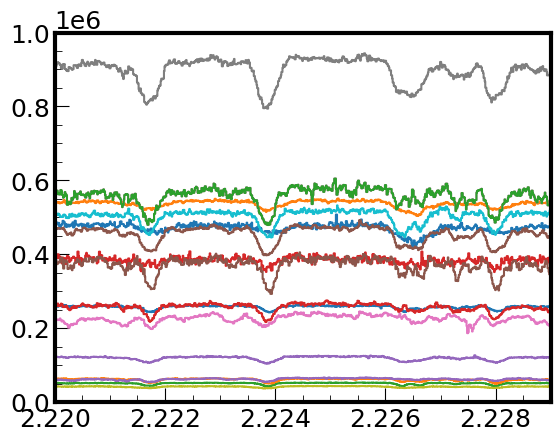

In [4]:
spec_stack = []
for i in range(len(standard_table)):
    spec_stack.append(Spectrum1D(spectral_axis=wavelen_stack[:,i]*u.micron,flux=raw_flux_stack[:,i]*u.ct,uncertainty=StdDevUncertainty(snr_stack[:,i]/raw_flux_stack[:,i])))

spec0 = Spectrum1D(spectral_axis=wavelen_stack[:,0]*u.micron,flux=raw_flux_stack[:,0]*u.ct)

fig, ax = plt.subplots()
for i in range(len(standard_table)):
    ax.step(spec_stack[i].spectral_axis,spec_stack[i].flux)
ax.set_xlim(2.22,2.229)
ax.set_ylim(0,1e6)
plt.show()

In [9]:
spec_stack[0]

<Spectrum1D(flux=<Quantity [683453., 683308., 665930., ...,     nan,     nan,     nan] ct>, spectral_axis=<SpectralAxis [1.99977199, 1.99979201, 1.99980203, ...,        nan,        nan,
          nan] micron>, uncertainty=StdDevUncertainty([0.00534977, 0.00534131, 0.00539121, ...,        nan,
                          nan,        nan]))>

In [8]:
cont_windows = [(2.22*u.um,2.2202*u.um),(2.2222*u.um,2.2228*u.um),(2.2242*u.um,2.2248*u.um)]
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    fitted_continuum = fit_generic_continuum(spec_stack[0])
cont_fit = fitted_continuum(spec_stack[0].spectral_axis)

NonFiniteValueError: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.